In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib
import json
import os

In [11]:
def load_and_prepare_data():
    """Loads mock data and generates features, including synthetic user interactions."""
    
    listings = pd.read_csv('mock_listings.csv')
    
    # --- Synthetic Interaction Generation ---
    n_interactions = 5000
    interactions = []
    wilaya_choices = listings['wilaya'].unique()
    
    for _ in range(n_interactions):
        listing = listings.sample(1).iloc[0]
        user_wilaya = listing['wilaya'] if np.random.random() > 0.3 else np.random.choice(wilaya_choices)
        
        # Interaction probability logic: match & premium quality boost click probability
        prob = 0.1
        if listing['wilaya'] == user_wilaya:
            prob += 0.4 # Strong boost for Wilaya match
        if listing['quality_grade'] == 'Premium':
            prob += 0.2 # Boost for high quality
        
        clicked = int(np.random.random() < prob)
        
        interactions.append({
            'listing_id': listing['listing_id'],
            'user_wilaya': user_wilaya,
            'clicked': clicked
        })
    
    df_interactions = pd.DataFrame(interactions)
    df = df_interactions.merge(listings, on='listing_id')
    
    # --- Feature Engineering ---
    print("Engineering features...")
    
    # 1. Wilaya Match (Crucial for filtering)
    df['wilaya_match'] = (df['user_wilaya'] == df['wilaya']).astype(int)
    
    # 2. Quality Score (Crucial for ranking)
    quality_map = {'Commercial': 1, 'Standard': 2, 'Premium': 3}
    df['quality_score'] = df['quality_grade'].map(quality_map)
    
    # Other features
    df['high_seller_rating'] = (df['seller_rating'] >= 4.5).astype(int)
    df['is_fresh_listing'] = (df['days_listed'] <= 7).astype(int) 
    
    feature_cols = [
        'wilaya_match', 'quality_score', 'price_dzd', 'price_per_kg',
        'available_quantity_kg', 'seller_rating', 'high_seller_rating', 
        'is_fresh_listing'
    ]
    
    # Prepare X (Features) and y (Target)
    X = df.dropna(subset=feature_cols)[feature_cols]
    y = df.dropna(subset=feature_cols)['clicked']
    
    return X, y

# Load and split the data
X, y = load_and_prepare_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data prepared. Training set size: **{len(X_train)}** samples.")

Engineering features...
Data prepared. Training set size: **4000** samples.


In [12]:
# --- Model Configuration ---
MODEL_TYPE = 'lgbm'
FILENAME = f'recommendation_model_{MODEL_TYPE}.pkl'

print(f"\n--- Starting {MODEL_TYPE.upper()} Training ---")

# Initialize LightGBM Classifier
model = lgb.LGBMClassifier(
    objective='binary',  # Prediction of a click/no-click event
    metric='auc',        # Optimize for Area Under the ROC Curve
    n_estimators=300, 
    max_depth=6, 
    learning_rate=0.1, 
    random_state=42,
    n_jobs=-1
)

# Train the model
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    'model': MODEL_TYPE.upper(),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'auc': roc_auc_score(y_test, y_pred_proba)
}

# Save the model
joblib.dump(model, FILENAME)

print(f"Model saved to **{FILENAME}**")
print("\nPerformance Metrics:")
print(pd.Series(metrics))

# Output metrics to a JSON file (useful for MLOps/tracking)
with open(f'model_metrics_{MODEL_TYPE}.json', 'w') as f:
    json.dump(metrics, f, indent=2)


--- Starting LGBM Training ---
[LightGBM] [Info] Number of positive: 1879, number of negative: 2121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469750 -> initscore=-0.121148
[LightGBM] [Info] Start training from score -0.121148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt


--- Feature Importance (Gain) ---


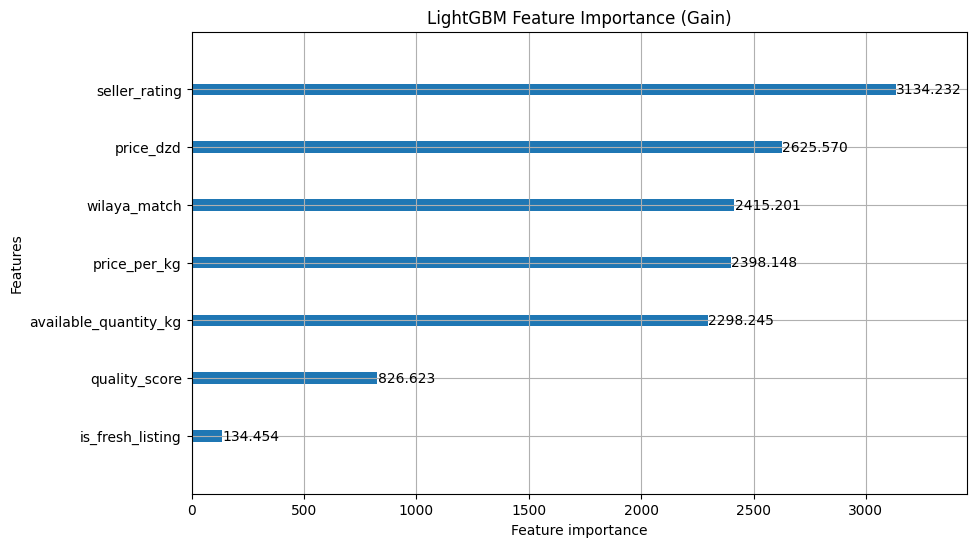

seller_rating            1749
price_dzd                1542
available_quantity_kg    1358
price_per_kg             1348
quality_score             225
wilaya_match              108
is_fresh_listing           52
high_seller_rating          0
dtype: int32


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Feature Importance (Gain) ---")
# Feature importance based on 'gain' is generally more reliable than 'split'
lgb.plot_importance(model, importance_type='gain', max_num_features=10, figsize=(10, 6), title='LightGBM Feature Importance (Gain)')
plt.show()

# Extract and display the top features
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_imp)